# XGBoost Demand-Forecast Model

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import mlflow
import getpass
import subprocess
import pickle
import numpy as np
from matplotlib import pyplot as plt
from pyngrok import ngrok, conf
from sklearn.preprocessing import MinMaxScaler

## Set up MLflow

In [3]:
mlflow_path = '../mlflow_results'
mlflow.set_tracking_uri(f'file:{mlflow_path}')

In [ ]:
mlflow.set_experiment('LSTM_retail_demand_analysis')

## Start the MLflow UI server

In [ ]:
subprocess.Popen(['mlflow', 'ui', '--host', '0.0.0.0', '--port', '5000', "--backend-store-uri", mlflow_path])

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel (ULR for MLFLow UI) \"{public_url}\" ')

## Load Data

In [7]:
with open('../resources/2_dataframes.pkl', 'rb') as f:
    dataframes = pickle.load(f)

In [8]:
df_holiday_events = dataframes['df_holiday_events']
df_items = dataframes['df_items']
df_oil = dataframes['df_oil']
df_stores = dataframes['df_stores']
df_transactions = dataframes['df_transactions']
df_train = dataframes['df_train']
df_filtered = dataframes['df_filtered']

## Filtering

In [9]:
min_date = '2014-01-01'
max_date = '2014-04-01'

df_filtered = df_filtered[(df_filtered.index >= min_date) & (df_filtered.index < max_date)]

## Preprocessing for LSTM

### Extracting the Series we want to predict (unit sales)

In [13]:
#values = df_filtered['unit_sales'].values.reshape(-1, 1)
values = df_filtered.values

### Train-Test Split

In [15]:
train_cut = int(len(values) * 0.7)
train_raw = values[:train_cut]
test_raw  = values[train_cut:]

### Scaling

In [17]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

### Transforming the Series into Supervised Windows

In [18]:
SEQ_LEN = 14  # days

def make_sequences(arr, seq_len):
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i : i + seq_len, :])   # seq_len rows × 1 feature
        y.append(arr[i + seq_len, 0])       # target is the very next value
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_scaled, SEQ_LEN)
X_test,  y_test  = make_sequences(test_scaled,  SEQ_LEN)

# X_train/test → (samples, time_steps, features) and y_train/test → (samples,).
print("Shapes  →  X_train:", X_train.shape,
      "   y_train:", y_train.shape,
      "   X_test:",  X_test.shape,
      "   y_test:",  y_test.shape)

Shapes  →  X_train: (48, 14, 6)    y_train: (48,)    X_test: (14, 14, 6)    y_test: (14,)


## Model Building

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

Use the Adam optimizer and the mean absolute error (MAE) as the loss function.

In [23]:
model.compile(optimizer='adam', loss='mae')

## Training

In [24]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=2 # This is so we can see on the screen one compact line per epoch (Epoch 1/30 loss=… val_loss=…).
)

Epoch 1/30
2/2 - 1s - 526ms/step - loss: 0.4259 - val_loss: 0.3793
Epoch 2/30
2/2 - 0s - 28ms/step - loss: 0.2006 - val_loss: 0.2278
Epoch 3/30
2/2 - 0s - 37ms/step - loss: 0.1331 - val_loss: 0.1728
Epoch 4/30
2/2 - 0s - 34ms/step - loss: 0.1561 - val_loss: 0.1712
Epoch 5/30
2/2 - 0s - 27ms/step - loss: 0.1438 - val_loss: 0.1840
Epoch 6/30
2/2 - 0s - 29ms/step - loss: 0.1377 - val_loss: 0.2133
Epoch 7/30
2/2 - 0s - 33ms/step - loss: 0.1039 - val_loss: 0.2452
Epoch 8/30
2/2 - 0s - 24ms/step - loss: 0.1052 - val_loss: 0.2687
Epoch 9/30
2/2 - 0s - 29ms/step - loss: 0.1473 - val_loss: 0.2728
Epoch 10/30
2/2 - 0s - 25ms/step - loss: 0.1260 - val_loss: 0.2605
Epoch 11/30
2/2 - 0s - 25ms/step - loss: 0.1153 - val_loss: 0.2499
Epoch 12/30
2/2 - 0s - 24ms/step - loss: 0.1189 - val_loss: 0.2392
Epoch 13/30
2/2 - 0s - 26ms/step - loss: 0.1041 - val_loss: 0.2317
Epoch 14/30
2/2 - 0s - 26ms/step - loss: 0.1091 - val_loss: 0.2314
Epoch 15/30
2/2 - 0s - 26ms/step - loss: 0.1126 - val_loss: 0.2302
Epo

## Generating Forecasts

In [25]:
y_pred_scaled = model.predict(X_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Convert forecasts back to real-world units.

In [28]:
# Create dummy arrays with the same shape as the original features
y_pred_full = np.zeros((len(y_pred_scaled), X_train.shape[2]))
y_pred_full[:, 0] = y_pred_scaled  # Put predictions in first column (unit_sales)

y_true_full = np.zeros((len(y_test), X_train.shape[2]))
y_true_full[:, 0] = y_test  # Put true values in first column (unit_sales)

# Inverse transform and extract only the unit_sales column
y_pred = scaler.inverse_transform(y_pred_full)[:, 0]
y_true = scaler.inverse_transform(y_true_full)[:, 0]

## Visualization

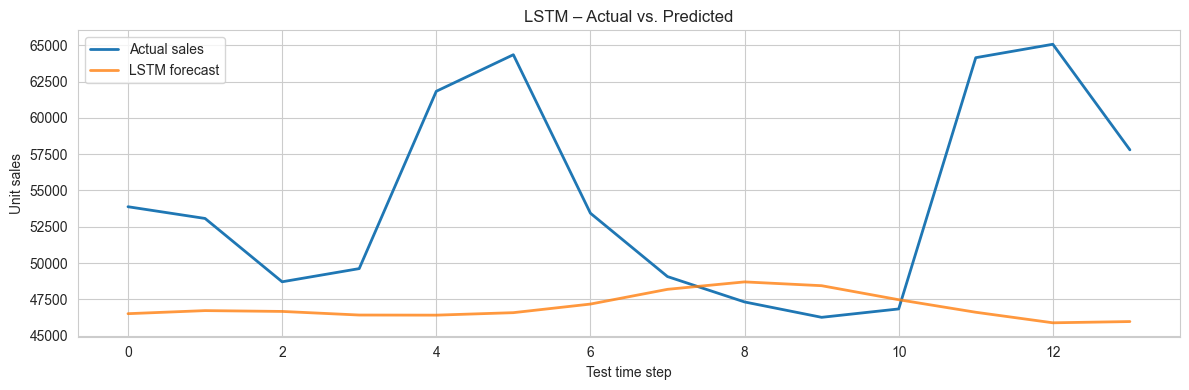

In [29]:
plt.figure(figsize=(12,4))
plt.plot(y_true, label="Actual sales", linewidth=2)
plt.plot(y_pred, label="LSTM forecast", linewidth=2, alpha=0.8)
plt.title("LSTM – Actual vs. Predicted")
plt.xlabel("Test time step")
plt.ylabel("Unit sales")
plt.legend()
plt.tight_layout()
plt.savefig('../resources/lstm_forecast.png')
plt.show()

## MAE Evaluation

In [30]:
mae = np.mean(np.abs(y_true - y_pred))
print(f"MAE={mae:6.2f}")

MAE=8001.53


## MLflow Tracking

In [ ]:
with mlflow.start_run(run_name='LSTM_retail_demand_analysis'):
    mlflow.log_params({
        'model_type': 'LSTM',
        'window': SEQ_LEN,
        'units': 64,
        'layers': 1,
        'epochs': 30,
        'batch_size': 32
    })
    mlflow.log_metric('mae', mae) # TODO add metrics
    mlflow.log_artifact('../resources/lstm_forecast.png')
    mlflow.keras.log_model(model, name='model')

## Save Model and Scaler

In [33]:
with open("../mlflow_results/models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [34]:
import os

model.save('model.keras')
os.rename('model.keras', '../mlflow_results/models/model.keras')

In [35]:
import json

feature_cols = ['unit_sales', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_std_7']

with open("../mlflow_results/models/feature_cols.json", "w") as f:
    json.dump(feature_cols, f)